# 01 &mdash; Exploratory Data Analysis

*(Data Analysis and Visualization 505067 &mdash; Final Report)*

**Authored by:** Nguyen Minh Triet

## Prerequisites

### Importing libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest

sns.set(style="whitegrid")

### Loading data

In [14]:
df = pd.read_csv("../data/salaries.csv")

### Data overview

**Explanation:**

Check dataset structure to confirm variable types, completeness, and non-null counts.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57194 entries, 0 to 57193
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           57194 non-null  int64 
 1   experience_level    57194 non-null  object
 2   employment_type     57194 non-null  object
 3   job_title           57194 non-null  object
 4   salary              57194 non-null  int64 
 5   salary_currency     57194 non-null  object
 6   salary_in_usd       57194 non-null  int64 
 7   employee_residence  57194 non-null  object
 8   remote_ratio        57194 non-null  int64 
 9   company_location    57194 non-null  object
 10  company_size        57194 non-null  object
dtypes: int64(4), object(7)
memory usage: 4.8+ MB


**Summary:**

All 11 columns are complete and correctly typed, no missing values.

### Checking null rows

In [5]:
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

**Summary:**

No missing entries across all variables.

### Checking duplicated rows

**Explanation:**

Duplicate rows can distort distribution and statistical analyses.

In [7]:
df.duplicated().sum()

np.int64(29883)

In [8]:
df = df.drop_duplicates()
df.shape

(27311, 11)

**Summary:**

Dataset contains 29,883 duplicated records that can be dropped using `df.drop_duplicates()`.

### Descriptive analysis

**Explanation:**

Compute summary statistics to evaluate central tendency, dispersion, and early signs of skew.

In [9]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,27311.000000,2.731100e+04,27311.000000,27311.000000
mean,2023.717989,1.633512e+05,152807.917286,26.511296
std,0.603236,2.892565e+05,75863.899248,43.860317
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2024.000000,9.840000e+04,98290.000000,0.000000
50%,2024.000000,1.420000e+05,141340.000000,0.000000
75%,2024.000000,1.950000e+05,193300.000000,100.000000
max,2024.000000,3.040000e+07,800000.000000,100.000000


**Summary:**

* Maximum salaries are much higher than median, which indicates a strong **right skew**.
* Mean exceeds median, meaning high-salary outliers influence central tendency.

$\Rightarrow$ Spread and extreme values suggest careful outlier handling is needed, especially for high-experience employees (Senior, Executive).

### Displaying sample rows

**Explanation:**

Preview first rows to confirm formatting, categorical variable consistency, and salary range.

In [10]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Developer,168276,USD,168276,US,0,US,M
1,2024,MI,FT,Developer,112184,USD,112184,US,0,US,M
2,2024,EN,FT,Developer,180000,USD,180000,US,0,US,M
3,2024,EN,FT,Developer,133500,USD,133500,US,0,US,M
4,2024,EN,FT,Developer,122000,USD,122000,US,0,US,M


**Summary:**

* All five records are Full-time Developers in 2024, US-based, on-site, with Medium-sized companies.
* Experience levels vary from Entry to Mid, showing diversity.

## Plots

### Histogram + KDE salary plot

**Explanation:**

Visualize distribution to confirm skewness and identify extreme values.

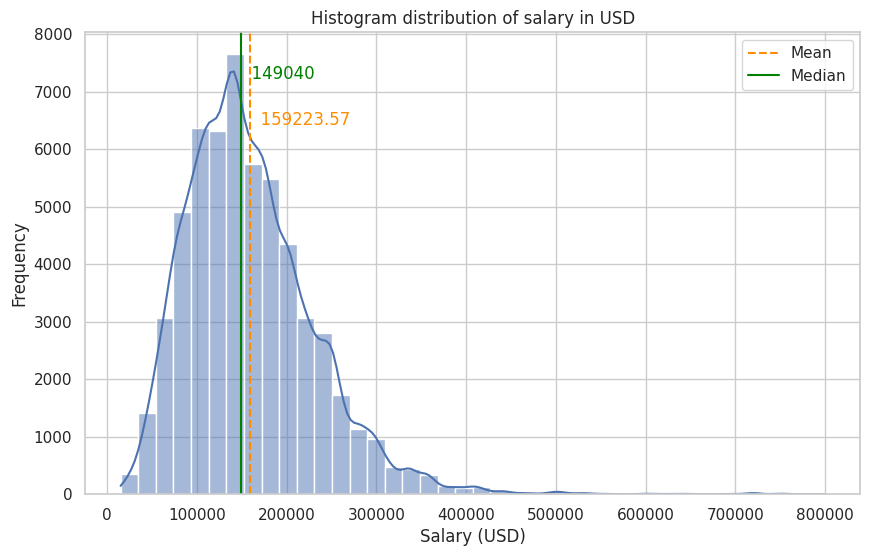

In [54]:
mean_salary = df["salary_in_usd"].mean()
median_salary = df["salary_in_usd"].median()

plt.figure(figsize=(10, 6))

sns.histplot(df["salary_in_usd"], bins=40, kde=True)

plt.axvline(mean_salary, color="darkorange", linestyle="--", label="Mean")
plt.text(mean_salary, plt.ylim()[1] * 0.8, f"  {mean_salary:.2f}", color="darkorange")

plt.axvline(median_salary, color="green", label="Median")
plt.text(median_salary, plt.ylim()[1] * 0.9, f"  {median_salary:.0f}", color="green")

plt.title("Histogram distribution of salary in USD")

plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")

plt.legend()

plt.show()

**Summary:**

* Distribution is strongly right-skewed.
* Mean being larger than median confirms asymmetry.
* High-salary tail likely corresponds to Senior/Executive employees; careful outlier handling is required.

### Boxplot salary

**Explanation:**

Quick check of spread and extreme values.

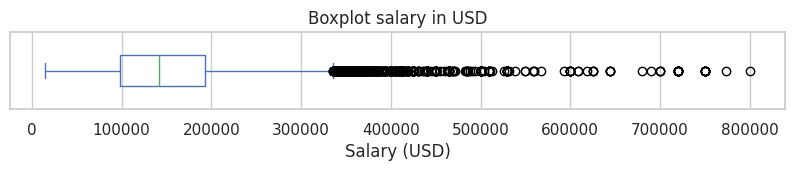

In [71]:
df["salary_in_usd"].plot.box(vert=False, widths=[0.4], figsize=(10, 1))

plt.title("Boxplot salary in USD")

plt.xlabel("Salary (USD)")
plt.yticks([])

plt.show()

**Summary:**

Extreme salaries visible; confirms long tail observed in histogram.

### Countplot experience levels

**Explanation:**

Visualize employee seniority across top 10 job titles.

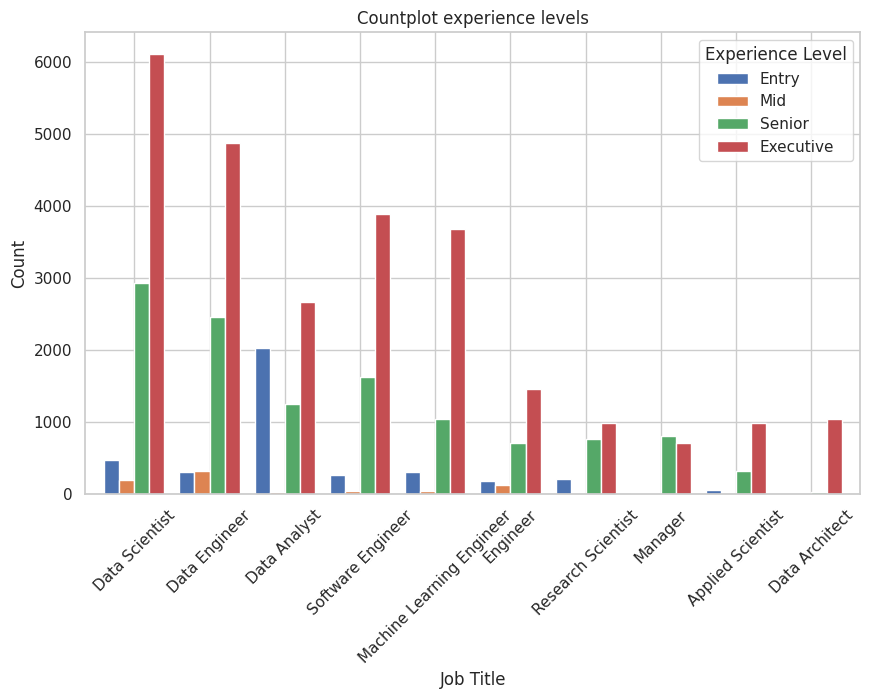

In [57]:
k_count = 10

counts = pd.crosstab(df["job_title"], df["experience_level"])
topk = counts.sum(axis=1).sort_values(ascending=False).head(k_count).index

counts.loc[topk].plot.bar(figsize=(10, 6), width=0.8)

plt.title("Countplot experience levels")

plt.xlabel("Job Title")
plt.ylabel("Count")

plt.xticks(rotation=45)

plt.legend(["Entry", "Mid", "Senior", "Executive"], title="Experience Level")

plt.show()

**Summary:**

* Senior and Executive dominate top roles.
* Entry surpasses Mid in many positions; is even higher then Senior for Data Analyst.

### Boxplot salary by remote ratio

**Explanation:**

Assess how remote work proportion affects salaries.

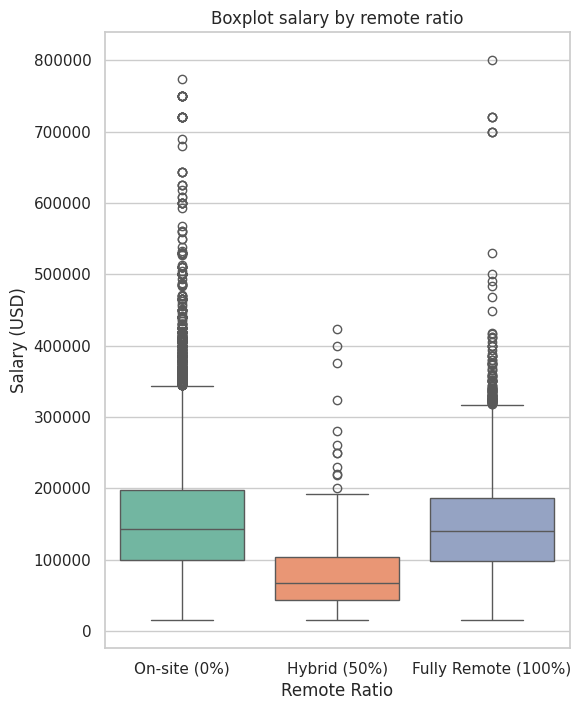

In [112]:
plt.figure(figsize=(6, 8))

sns.boxplot(data=df, x="remote_ratio", y="salary_in_usd", hue="remote_ratio", palette="Set2")

plt.title("Boxplot salary by remote ratio")

plt.xlabel("Remote Ratio")
plt.ylabel("Salary (USD)")

plt.xticks(range(3), ["On-site (0%)", "Hybrid (50%)", "Fully Remote (100%)"])

plt.legend().set_visible(False)

plt.show()

**Summary:**

* Fully remote employees get paid roughly the same as on-site employees.
* Hybrid roles show lower median and IQR.

$\Rightarrow$ Remote work has become relevant in recent years.

## Outlier detection/removal methods

### IQR

**Explanation:**

Assumes outliers are outside the interquartile (IQR) range.

In [42]:
target_col = "salary_in_usd"

q1 = df[target_col].quantile(0.25)
q3 = df[target_col].quantile(0.75)

iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q1 + 1.5 * iqr

df_iqr = df[(df[target_col] >= lower) & (df[target_col] <= upper)]

print(f"Cleaned: {len(df)} → {len(df_iqr)}")

Cleaned: 57194 → 50548


**Summary:**

* Removes large portion of outliers.
* Likely too aggressive for high-experience valid entries.

### Z-score

**Explanation:**

Calculate $Z = \frac{x - \mu}{\sigma}$ for each data point $x$ and remove ones that has $|Z| > 3$. Assumes approximate normality.

In [41]:
target_col = "salary_in_usd"

z = stats.zscore(df[target_col])

df_z = df[np.abs(z) < 3]

print(f"Cleaned: {len(df)} → {len(df_z)}")

Cleaned: 57194 → 56671


**Summary:**

* Less aggressive than IQR.
* Unsuitable due to skewed distribution.

### Median Absolute Deviation (MAD)

**Explanation:**

Modified Z-score method that use median instead of mean; suitable for skewed distributions.

In [43]:
target_col = "salary_in_usd"

median = df[target_col].median()
mad = np.median(np.abs(df[target_col] - median))
mod_z = 0.6745 * (df[target_col] - median) / mad

df_mad = df[np.abs(mod_z) < 3.5]

print(f"Cleaned: {len(df)} → {len(df_mad)}")

Cleaned: 57194 → 56672


**Summary:**

* Effectively removes extreme outliers while preserving valid high-salary entries.
* Selected as preferred method in the report.

### Isolation Forest

**Explanation:**

Randomly splits data into branches (trees); outliers require fewer splits to isolate, meaning they require fewer, while normal points need more.

In [47]:
target_col = "salary_in_usd"

iso = IsolationForest(contamination=0.02, random_state=42)
iso_labels = iso.fit_predict(df[[target_col]])

df_iso = df[iso_labels == 1]

print(f"Cleaned: {len(df)} → {len(df_iso)}")

Cleaned: 57194 → 56116


**Summary:**

* Effective for high-dimensional data.
* Less interpretable in a statistical context.
* Heavy reliance on `contamination`&mdash;percentage of potential outliers.

### Boxplot comparisons

**Explanation:**

Visual comparison of original data and outlier removal approaches.

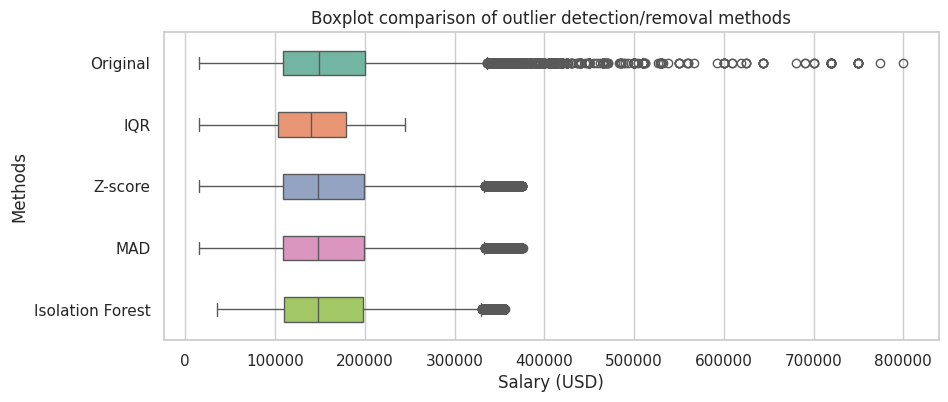

In [52]:
plt.figure(figsize=(10, 4))

sns.boxplot(
    data=pd.concat([
        df.assign(source="Original"),
        df_iqr.assign(source="IQR"),
        df_z.assign(source="Z-score"),
        df_mad.assign(source="MAD"),
        df_iso.assign(source="Isolation Forest"),
    ], ignore_index=True),
    x=target_col, y="source", hue="source", width=0.4, palette="Set2",
)

plt.title("Boxplot comparison of outlier detection/removal methods")

plt.xlabel("Salary (USD)")
plt.ylabel("Methods")

plt.show()

**Summary:**

* MAD maintains the majority of valid data while removing true outliers.
* IQR removes too many high-salary points.
* Z-score and Isolation Forest provide alternative perspectives.

## Conclusion

* The dataset contains 27,311 unique records with 11 variables and no missing values.
* Salary is strongly right-skewed, with some large outliers in the range of Senior and Executive salaries.
* The MAD (Median Absolute Deviation) method is preferred to remove outliers.